# Matching documents across languages with Universal Sentence Encoding and Tensorflow

What do we do when we have terabytes of documents scattered across multiple languages? Well, if we find *one* document that's interesting, we might want to ask the computer to anything that's similar to it. If we ask especially politely, we can **have it find similar documents even in a different language.**

I found out about this technique based on [a writeup of Quartz's analysis of the Luanda Leaks](https://qz.com/1786896/ai-for-investigations-sorting-through-the-luanda-leaks/). I recommend giving it a read-through before you go through here, just for a bit of context.

> **Note:** I talk about *documents* a lot in this section, but what we're really interested in is *sentences*. When we get to the next section - how to apply these techniques to large datasets - the difference will become more clear.

Let's say we have **a handful of sentences.**

<p class="reading-options">
  <a class="btn" href="/text-analysis/document-similarity-over-different-languages">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/text-analysis/notebooks/Document similarity over different languages.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/text-analysis/notebooks/Document similarity over different languages.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

In [21]:
import pandas as pd

sentences = [
    "Molly ate a fish",
    "Jen consumed a carp",
    "I would like to sell you a house",
    "Я пытаюсь купить дачу", # I'm trying to buy a summer home
    "J'aimerais vous louer un grand appartement", # I would like to rent a large apartment to you
    "This is a wonderful investment opportunity",
    "Это прекрасная возможность для инвестиций", # investment opportunity
    "C'est une merveilleuse opportunité d'investissement", # investment opportunity
    "これは素晴らしい投資機会です", # investment opportunity
    "野球はあなたが思うよりも面白いことがあります", # baseball can be more interesting than you think
    "Baseball can be interesting than you'd think"
]

I used Google Translate to mix and match between languages - some Russian, some Japanese, some French - to varying degrees of similarity. Some are exactly the same (investment opportunities), while others are only roughly about the same topic (renting or buying houses/apartments).

Without spending time going through them one-by-one ourselves, **how can we find sentences that are similar to one another?**

## Old method: Counting words

Traditionally, document similarity is based on **the words two documents have in common.**

First, we'll count the number of times each word appears.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer 

vectorizer = CountVectorizer(binary=True)
matrix = vectorizer.fit_transform(sentences)
counts = pd.DataFrame(
    matrix.toarray(),
    index=sentences,
    columns=vectorizer.get_feature_names())
counts.head()

,aimerais,appartement,ate,baseball,be,can,carp,consumed,est,fish,...,возможность,дачу,для,инвестиций,купить,прекрасная,пытаюсь,это,これは素晴らしい投資機会です,野球はあなたが思うよりも面白いことがあります
Molly ate a fish,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Jen consumed a carp,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
I would like to sell you a house,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Я пытаюсь купить дачу,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
J'aimerais vous louer un grand appartement,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then we'll see how many words each sentence has in common with each other sentence. The more words two sentences have in common, the higher their similarity should be.

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the similarities using the word counts
similarities = cosine_similarity(matrix)

# Make a fancy colored dataframe about it
pd.DataFrame(similarities,
             index=sentences,
             columns=sentences) \
            .style \
            .background_gradient(axis=None)

,Molly ate a fish,Jen consumed a carp,I would like to sell you a house,Я пытаюсь купить дачу,J'aimerais vous louer un grand appartement,This is a wonderful investment opportunity,Это прекрасная возможность для инвестиций,C'est une merveilleuse opportunité d'investissement,これは素晴らしい投資機会です,野球はあなたが思うよりも面白いことがあります,Baseball can be interesting than you'd think
Molly ate a fish,1,0,0,0,0,0,0,0,0,0,0
Jen consumed a carp,0,1,0,0,0,0,0,0,0,0,0
I would like to sell you a house,0,0,1,0,0,0,0,0,0,0,0.154303
Я пытаюсь купить дачу,0,0,0,1,0,0,0,0,0,0,0
J'aimerais vous louer un grand appartement,0,0,0,0,1,0,0,0,0,0,0
This is a wonderful investment opportunity,0,0,0,0,0,1,0,0,0,0,0
Это прекрасная возможность для инвестиций,0,0,0,0,0,0,1,0,0,0,0
C'est une merveilleuse opportunité d'investissement,0,0,0,0,0,0,0,1,0,0,0
これは素晴らしい投資機会です,0,0,0,0,0,0,0,0,1,0,0
野球はあなたが思うよりも面白いことがあります,0,0,0,0,0,0,0,0,0,1,0


Pretty boring, right? These sentences share almost no words (ignoring things like **a** or **the**), so the only two sentences that are actually marked as similar are...

* `Baseball can be interesting than you'd think`
* `I would like to sell you a house`

...because they both contain the word **you**! While it's useless, it isn't unexpected. These sentences are all in different languages, how in the world are we supposed to judge whether they're similar or not?

## New method: Universal sentence encoder

Once upon a time we talked about [word embeddings](https://investigate.ai/text-analysis/word-embeddings/), which are ways for each word to have multiple dimensions of meaning. "cat" and "lion" might both be catlike, while "lion" and "wolf" are both wild.

Imagine a graph that looks like this, but with *three hundred dimensions*:

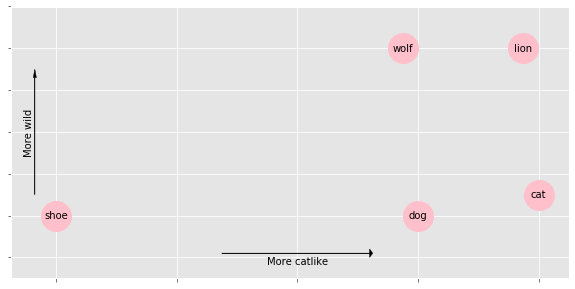

To find words that are similar, you just find ones that are close to each other in that 300-dimension space: a certain amount about cats, a certain amount wild, a certain amount edible, a certain amount red, etc etc etc. Notice in the chart above, `shoe` is far far off to the left: that means it isn't very similar to those other four words! If you haven't seen it yet, it's a great idea to go read our [word embeddings page](https://investigate.ai/text-analysis/word-embeddings/) for more details.

Researchers took this idea of word embeddings and used some [fun computer magic](https://arxiv.org/abs/1907.04307) to take it one step further: they learned to apply it **across different languages!**

We aren't talking just strict translation! While yes, `cat` and `gato` and `猫` all translate to the same word, multi-language *word embeddings* mean a lot more. A sentence that talks about `meowing` can be marked as similar to one that talks about `gatos`, even though the words aren't exact translation matches, *just because both of those words are cat-related!*

The [Multilingual Universal Sentence Encoder](https://ai.googleblog.com/2019/07/multilingual-universal-sentence-encoder.html) is our new best friend. Using it along with [Tensorflow](tensorflow.org), we'll be able to match up our simiarly sentences, even if they're in completely different languages.

> Big thanks to [Jeremy Merrill's tensorflow v1 example](https://github.com/Quartz/aistudio-searching-data-dumps-with-use/blob/master/Searching%20with%20USE.ipynb) as inspo, even though I can't agree with his choice in bagels

And hey, 300 dimensions? Forget about that, let's upgrade to *512*.

### The code

If you need to install tensorflow or its associated packages, uncomment and run the next line. Otherwise we're pretty much good to go!

In [26]:
# !pip install tensorflow tensorflow_hub tensorflow_text

In [27]:
# Import tensorflow and friends

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

We'll start by loading the Multilingual Universal Sentence Encoder. We're using version 3, which is super user-friendly.

> I *believe* this requires that we're Tensorflow v2, but don't quote me on that.

In [29]:
# Load the Multilingual Universal Sentence Encoder, v3
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

We can now use this `embed` to create our multilingual sentence embeddings. Congratulations!

What's it look like when we run an encoding? Let's find the **512 dimensions of knowledge about bagels.**

In [30]:
embed("the only kind of bagel is everything")

<tf.Tensor: id=57071, shape=(1, 512), dtype=float32, numpy=
array([[-3.69759873e-02,  3.79814878e-02, -1.50387250e-02,
        -3.46106850e-02,  2.21144240e-02,  5.16897328e-02,
         8.20917264e-03,  1.37943355e-02, -3.79155353e-02,
        -1.65961019e-03,  5.37911337e-03,  1.48542887e-02,
         7.86846355e-02, -2.62473281e-02,  6.43585697e-02,
         4.98673990e-02, -7.89802819e-02, -3.48499864e-02,
         7.56129548e-02, -2.97897067e-02,  1.87768098e-02,
         6.11422174e-02,  9.61908046e-03,  8.94820690e-03,
        -6.60641526e-04, -3.11440807e-02, -1.06579633e-02,
        -3.30661237e-02,  5.29161189e-03,  4.56077345e-02,
        -2.63070073e-02, -2.36417707e-02,  4.46549021e-02,
        -5.67555539e-02,  5.66278994e-02,  4.85747606e-02,
         7.41910040e-02,  2.24836003e-02, -1.96227692e-02,
        -3.48150916e-02, -7.31992200e-02, -6.30672723e-02,
         3.54410671e-02,  1.33525990e-02,  7.31556565e-02,
         3.63616413e-03, -5.82444593e-02, -2.85111647e-

Fun, right? So now we're going to feed **all of our sentences** into the encoder. Each sentences will get its own 512-dimensional representation, and then we'll use that to see which ones are close to each other.

In [31]:
# Generate embeddings for each sentence
embeddings = embed(sentences)

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarities exactly the same as we did before!
similarities = cosine_similarity(embeddings)

# Turn into a dataframe
pd.DataFrame(similarities,
            index=sentences,
            columns=sentences) \
            .style \
            .background_gradient(axis=None)

,Molly ate a fish,Jen consumed a carp,I would like to sell you a house,Я пытаюсь купить дачу,J'aimerais vous louer un grand appartement,This is a wonderful investment opportunity,Это прекрасная возможность для инвестиций,C'est une merveilleuse opportunité d'investissement,これは素晴らしい投資機会です,野球はあなたが思うよりも面白いことがあります,Baseball can be interesting than you'd think
Molly ate a fish,1,0.527974,0.069064,0.0583723,0.0330744,-0.013103,-0.0262051,0.0200289,-0.053362,0.081585,0.119151
Jen consumed a carp,0.527974,1,0.101584,0.138269,0.0447615,0.00845337,-0.0199944,0.0514989,0.00944404,0.0830695,0.147007
I would like to sell you a house,0.069064,0.101584,1,0.52998,0.542384,0.231101,0.215794,0.187328,0.214123,0.149138,0.182979
Я пытаюсь купить дачу,0.0583723,0.138269,0.52998,1,0.30713,0.156921,0.145542,0.169162,0.13936,-0.0209739,0.0458156
J'aimerais vous louer un grand appartement,0.0330744,0.0447615,0.542384,0.30713,1,0.283597,0.275903,0.279139,0.2666,0.162576,0.169971
This is a wonderful investment opportunity,-0.013103,0.00845337,0.231101,0.156921,0.283597,1,0.920411,0.902763,0.90484,0.0907904,0.191868
Это прекрасная возможность для инвестиций,-0.0262051,-0.0199944,0.215794,0.145542,0.275903,0.920411,1,0.885628,0.824693,0.0500936,0.147731
C'est une merveilleuse opportunité d'investissement,0.0200289,0.0514989,0.187328,0.169162,0.279139,0.902763,0.885628,1,0.831138,0.094717,0.192856
これは素晴らしい投資機会です,-0.053362,0.00944404,0.214123,0.13936,0.2666,0.90484,0.824693,0.831138,1,0.104263,0.230147
野球はあなたが思うよりも面白いことがあります,0.081585,0.0830695,0.149138,-0.0209739,0.162576,0.0907904,0.0500936,0.094717,0.104263,1,0.703603


**Magic, right?**

The ones about housing are all grouped together, investment opportunities are marked as similar, and baseball as well. You'll notice it (somewhat obviously) even works within the same language - **Jen consumed a carp** and **Molly ate a fish** are both similar.

While this is fun conceptually and all, next up we'll see how to put this into production use!